In [1]:
%reload_ext eradiate.notebook.tutorials

*Last updated: 2025-07-03 11:57 (eradiate v0.31.0.dev0)*

We start by activating the IPython extension and importing and aliasing a few useful components. We also select the monochromatic mode.

In [2]:
%load_ext eradiate

import eradiate
import matplotlib.pyplot as plt
import numpy as np
from eradiate import scenes as ertsc
from eradiate import unit_registry as ureg

eradiate.set_mode("mono")

We set the computational mode to monochromatic, since we will be simulating scenes without atmospheres. Hence the correlated-*k* distribution method will not be useful here.

Next we set up convenience functions for plotting BRF results and visualizing camera renders.

In [3]:
def show_camera(
    exp,
    measure_id,
    robust=True,
    add_colorbar=False,
    vmin=None,
    vmax=None,
):
    """
    Display the output of a monochromatic camera measure.
    """
    _, ax = plt.subplots(1, 1)
    exp.results[measure_id]["radiance"].squeeze(drop=True).plot.imshow(
        ax=ax,
        origin="upper",
        cmap="Greys_r",
        vmin=vmin,
        vmax=vmax,
        robust=robust,
        add_colorbar=add_colorbar,
    )
    ax.set_aspect(1)  # Ensures that pixels are represented as squares
    plt.show()
    plt.close()

def show_brf(exp, measure_id):
    """
    Display the BRF output of a distant radiance measure.
    """
    _, ax = plt.subplots(1, 1)
    exp.results[measure_id]["brf"].squeeze(drop=True).plot(
        ax=ax, x="vza", linestyle=":", marker="."
    )
    plt.show()
    plt.close()

In [4]:
lambertian_surface=ertsc.surface.BasicSurface(
    shape=ertsc.shapes.RectangleShape(edges=10.0 * ureg.m),
    bsdf=ertsc.bsdfs.LambertianBSDF(reflectance=0.5),
)

In [5]:
camera_oblique = ertsc.measure.PerspectiveCameraMeasure(
    id="camera_oblique",
    origin=[15, 15, 15] * ureg.m,
    target=[0, 0, 0] * ureg.m,
    up=[0, 0, 1],
    film_resolution=(320, 240),
    spp=512,
)

In [6]:
exp = eradiate.experiments.CanopyExperiment(
    surface=lambertian_surface,
    measures=camera_oblique,
)

We run the simulation and use the convenience function defined above to visualize the result.

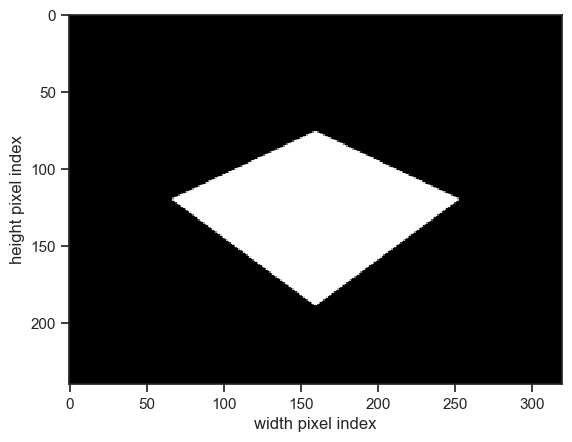

In [7]:
eradiate.run(exp)
show_camera(exp, "camera_oblique")

In [8]:
homogeneous_canopy = ertsc.biosphere.DiscreteCanopy.homogeneous(
    l_vertical=1.0 * ureg.m,
    l_horizontal=10.0 * ureg.m,
    lai=2.0,
    leaf_radius=10 * ureg.cm,
)

We create a new experiment object, which contains the canopy we just defined.

**Note:** We can now define the surface through its BSDF only, because the size of the rectangular shape is defined by the width of the canopy.

In [9]:
exp = eradiate.experiments.CanopyExperiment(
    surface=ertsc.bsdfs.LambertianBSDF(reflectance=0.5),
    canopy=homogeneous_canopy,
    measures=camera_oblique,
)

We run the experiment and display the result.

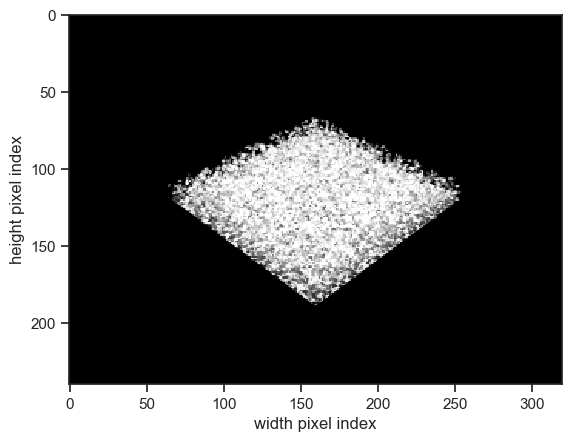

In [10]:
eradiate.run(exp)
show_camera(exp, "camera_oblique")

In [11]:
hdistant = eradiate.scenes.measure.HemisphericalDistantMeasure(spp=10000)

In [12]:
exp = eradiate.experiments.CanopyExperiment(
    surface=ertsc.bsdfs.LambertianBSDF(reflectance=0.5),
    illumination=ertsc.illumination.DirectionalIllumination(
        zenith=30.0 * ureg.deg,
        azimuth=45.0 * ureg.deg,
    ),
    canopy=homogeneous_canopy,
    measures=hdistant,
)
ds = eradiate.run(exp)
ds

<xarray.Dataset> Size: 42kB
Dimensions:     (sza: 1, saa: 1, w: 1, y_index: 32, x_index: 32)
Coordinates:
  * sza         (sza) float64 8B 30.0
  * saa         (saa) float64 8B 45.0
  * w           (w) float64 8B 550.0
  * y_index     (y_index) int64 256B 0 1 2 3 4 5 6 7 ... 24 25 26 27 28 29 30 31
    y           (y_index) float64 256B 0.0 0.03226 0.06452 ... 0.9355 0.9677 1.0
  * x_index     (x_index) int64 256B 0 1 2 3 4 5 6 7 ... 24 25 26 27 28 29 30 31
    x           (x_index) float64 256B 0.0 0.03226 0.06452 ... 0.9355 0.9677 1.0
    vza         (x_index, y_index) float64 8kB 86.47 86.47 86.47 ... 86.47 86.47
    vaa         (x_index, y_index) float64 8kB 225.0 222.1 219.2 ... 42.1 45.0
Data variables:
    radiance    (w, y_index, x_index, saa, sza) float64 8kB 0.2602 ... 0.2656
    brdf        (w, y_index, x_index, saa, sza) float64 8kB 0.1574 ... 0.1607
    brf         (w, y_index, x_index, saa, sza) float64 8kB 0.4946 ... 0.505
    irradiance  (sza, saa, w) float64 8B 1.652

We can now visualise the data quickly using xarray's built-in plotting facilities:

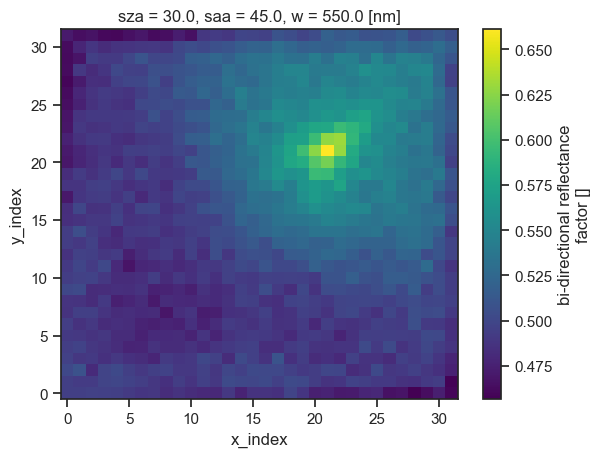

In [13]:
ds["brf"].squeeze().plot()

In [14]:
mdistant = ertsc.measure.MultiDistantMeasure.hplane(
    id="toa_brf",
    zeniths=np.arange(-75, 76, 5),
    azimuth=45 * ureg.deg,
    srf={"type": "multi_delta", "wavelengths": 550.0 * ureg.nm},
    spp=10000,
)

exp = eradiate.experiments.CanopyExperiment(
    surface=ertsc.bsdfs.LambertianBSDF(reflectance=0.5),
    illumination=ertsc.illumination.DirectionalIllumination(
        zenith=30.0 * ureg.deg,
        azimuth=45.0 * ureg.deg,
    ),
    canopy=homogeneous_canopy,
    measures=mdistant,
)

ds = eradiate.run(exp)
ds

<xarray.Dataset> Size: 2kB
Dimensions:     (sza: 1, saa: 1, w: 1, y_index: 1, x_index: 31)
Coordinates:
  * sza         (sza) float64 8B 30.0
  * saa         (saa) float64 8B 45.0
  * w           (w) float64 8B 550.0
  * y_index     (y_index) int64 8B 0
    y           (y_index) float64 8B 0.0
  * x_index     (x_index) int64 248B 0 1 2 3 4 5 6 7 ... 23 24 25 26 27 28 29 30
    x           (x_index) float64 248B 0.0 0.03333 0.06667 ... 0.9333 0.9667 1.0
    vza         (x_index, y_index) int64 248B -75 -70 -65 -60 ... 60 65 70 75
    vaa         (x_index, y_index) int64 248B 45 45 45 45 45 ... 45 45 45 45 45
Data variables:
    radiance    (w, y_index, x_index, saa, sza) float64 248B 0.2538 ... 0.279
    brdf        (w, y_index, x_index, saa, sza) float64 248B 0.1536 ... 0.1689
    brf         (w, y_index, x_index, saa, sza) float64 248B 0.4825 ... 0.5305
    irradiance  (sza, saa, w) float64 8B 1.652

Visualisation is also greatly facilitated by xarray's plotting features. We explicitly use the `vza` (viewing zenith angle) coordinate as the *x* coordinate. We see the retro-reflective "hot spot" in the illumination direction (30°). Also note how variance typical of Monte Carlo methods appears: it can be reduced by increasing the sample count of the measure (`spp` parameter).

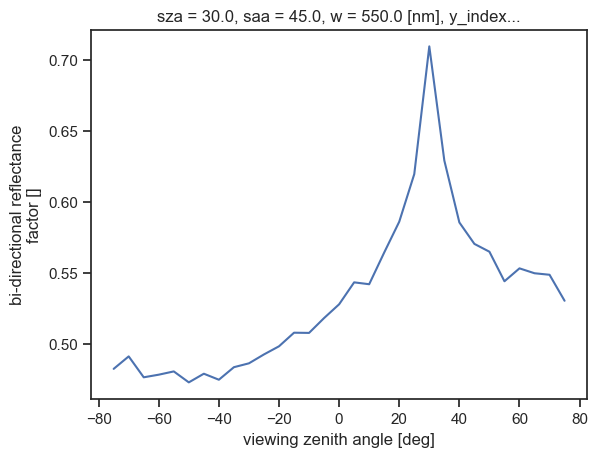

In [15]:
ds.brf.plot(x="vza");

In [16]:
exp = eradiate.experiments.CanopyExperiment(
    surface=ertsc.bsdfs.LambertianBSDF(reflectance=0.5),
    canopy=homogeneous_canopy,
    padding=1,
    measures=camera_oblique,
)

Let's run this experiment and visualise the results:

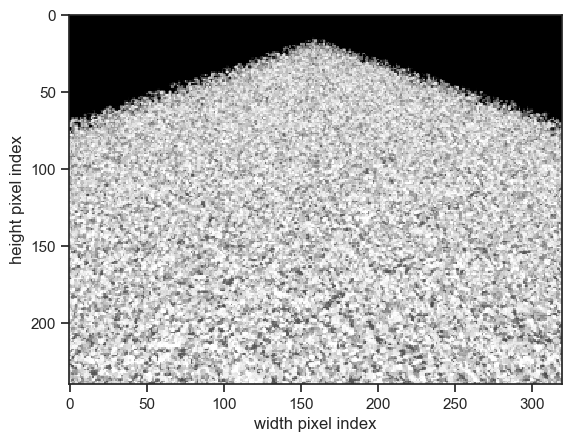

In [17]:
eradiate.run(exp)
show_camera(exp, "camera_oblique")

Our unit cell is now surrounded by a row of clones of itself: this amounts to 8 clones. Let's increase padding to 2 (we now have 8 + 16 = 24 clones):

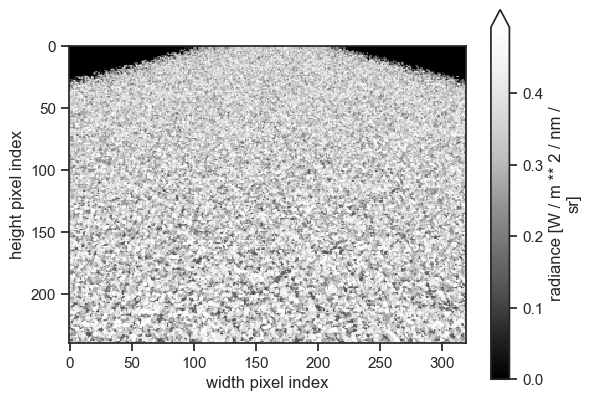

In [18]:
exp = eradiate.experiments.CanopyExperiment(
    surface=ertsc.bsdfs.LambertianBSDF(reflectance=0.5),
    canopy=homogeneous_canopy,
    padding=2,
    measures=camera_oblique,
)
eradiate.run(exp)
show_camera(exp, "camera_oblique", add_colorbar=True)

We can see that the rendering time increases with padding. This is due to more pixels of the final image requiring the simulation of multiple scattering and rendering time should become approximately constant with larger padding values:

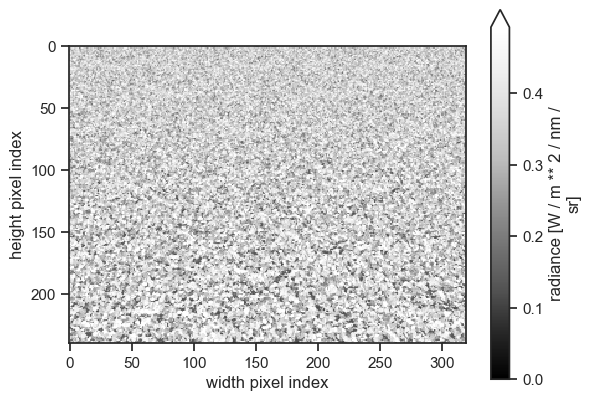

In [19]:
exp = eradiate.experiments.CanopyExperiment(
    surface=ertsc.bsdfs.LambertianBSDF(reflectance=0.5),
    canopy=homogeneous_canopy,
    padding=25,
    measures=camera_oblique,
)
eradiate.run(exp)
show_camera(exp, "camera_oblique", vmin=0.0, add_colorbar=True)